<a href="https://colab.research.google.com/github/SophiaKrammer/BachelorThesis/blob/main/Bachelorarbeit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


# Datei laden
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("Housing.csv")
df.head()


df.info(), df.head()




Saving Housing.csv to Housing.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


(None,
       price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
 0  13300000  7420         4          2        3      yes        no       no   
 1  12250000  8960         4          4        4      yes        no       no   
 2  12250000  9960         3          2        2      yes        no      yes   
 3  12215000  7500         4          2        2      yes        no      yes   
 4  11410000  7420         4          1        2      yes       yes      yes   
 
   hotwaterheating airconditioning  parking prefarea furnishingstatus  
 0              no             yes        2      yes        furnished  
 1              no             yes        3       no        furnished  
 2              no              no        2      yes   semi-furnished  
 3              no             yes        3      yes        furnished  
 4              no             yes        2       no        furnished  )

In [ ]:
#Datensatz bereinigen
df.isnull().sum()
df.describe()
df["bedrooms"].value_counts()
df.sort_values("area", ascending=False).head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
125,5943000,15600,3,1,1,yes,no,no,no,yes,2,no,semi-furnished
10,9800000,13200,3,1,2,yes,no,yes,no,yes,2,yes,furnished
66,6930000,13200,2,1,1,yes,no,yes,yes,no,1,no,furnished
403,3500000,12944,3,1,1,yes,no,no,no,no,0,no,unfurnished


In [ ]:

df_cleaned = df.copy()

# Spaltennamen vereinheitlichen
df_cleaned.columns = df_cleaned.columns.str.strip().str.lower()

# Strings in Kleinbuchstaben umwandeln
for col in df_cleaned.select_dtypes(include="object").columns:
    df_cleaned[col] = df_cleaned[col].str.strip().str.lower()

# Ausreißer kennzeichnen
df_cleaned["extreme_area"] = df_cleaned["area"] > 13000

# Fehlende Werte prüfen
print("Fehlende Werte nach Bereinigung:")
print(df_cleaned.isnull().sum())

# Plausibilitätsprüfung
print("\nGrößte Wohnflächen (zur manuellen Prüfung):")
print(df_cleaned.sort_values("area", ascending=False).head(5))

# df_cleaned.to_csv("housing_cleaned.csv", index=False)


Fehlende Werte nach Bereinigung:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
extreme_area        0
dtype: int64

Größte Wohnflächen (zur manuellen Prüfung):
        price   area  bedrooms  bathrooms  stories mainroad guestroom  \
7    10150000  16200         5          3        2      yes        no   
125   5943000  15600         3          1        1      yes        no   
10    9800000  13200         3          1        2      yes        no   
66    6930000  13200         2          1        1      yes        no   
403   3500000  12944         3          1        1      yes        no   

    basement hotwaterheating airconditioning  parking prefarea  \
7         no              no              no        0       no   
125       no              no  

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features und Zielspalte trennen
X = df_cleaned.drop(["price", "extreme_area"], axis=1)
y = df_cleaned["price"]

# Spaltenarten identifizieren
categorical_features = X.select_dtypes(include="object").columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# One-Hot-Encoding für kategorische Spalten
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"  # numerische Spalten bleiben unverändert
)

# Preprocessing + Modell
pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
pipeline.fit(X_train, y_train)

# Vorhersagebeispiel
sample = X_test.iloc[[0]]
prediction = pipeline.predict(sample)[0]
print(f"Vorhergesagter Preis für Beispielhaus: {round(prediction):,} INR")


Vorhergesagter Preis für Beispielhaus: 5,377,680 INR


In [ ]:
!pip install shap


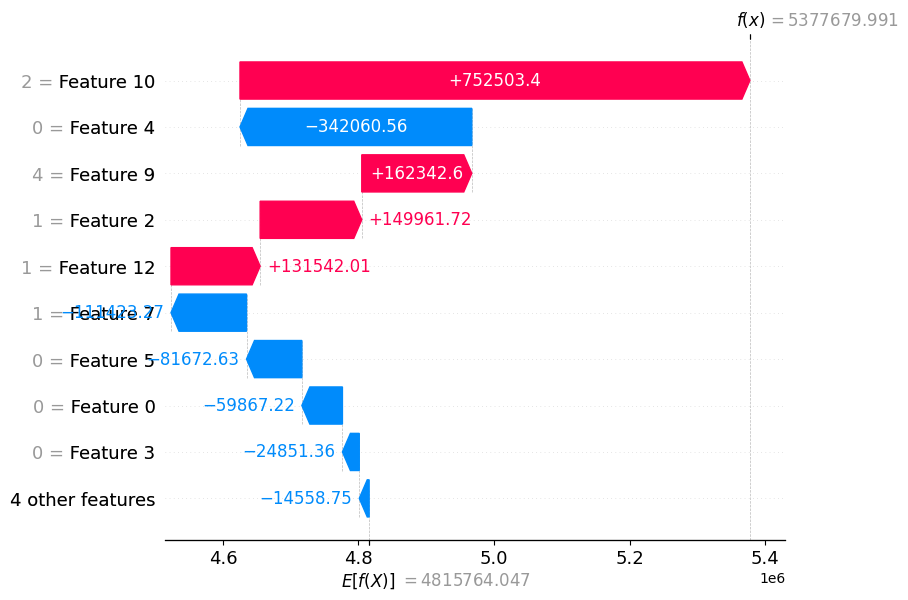

In [ ]:
import shap

preprocessor = pipeline.named_steps["preprocessing"]
model = pipeline.named_steps["model"]

# Trainingsdaten vorbereiten
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# SHAP-Explainer initialisieren für tree-based model
explainer = shap.Explainer(model, X_train_processed)

# SHAP-Werte für die erste Testinstanz
sample_instance = X_test.iloc[[0]]
sample_instance_processed = preprocessor.transform(sample_instance)

shap_values = explainer(sample_instance_processed)

# Visualisierung: Waterfall-Plot
shap.plots.waterfall(shap_values[0])



--- SHAP Explanation for Instance 0 ---


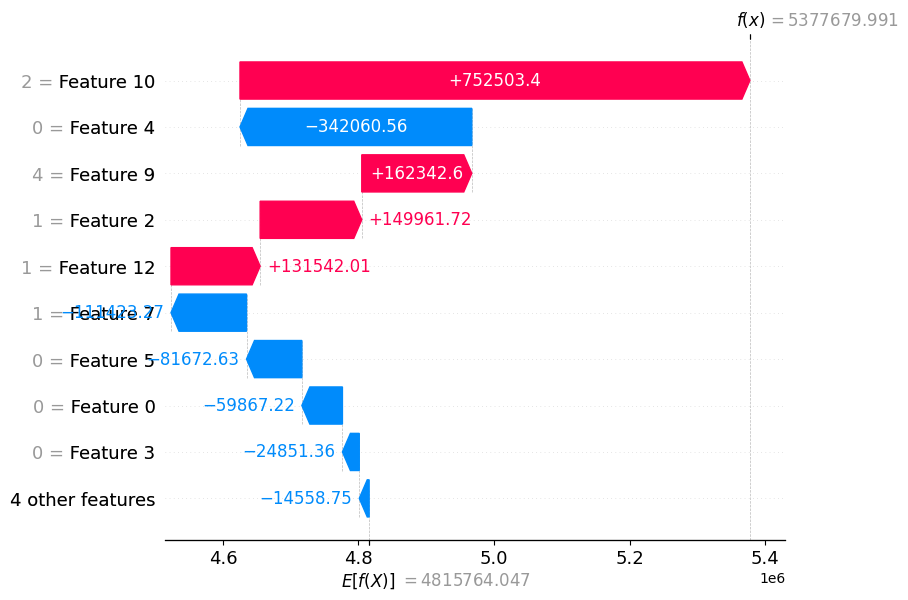


--- SHAP Explanation for Instance 1 ---


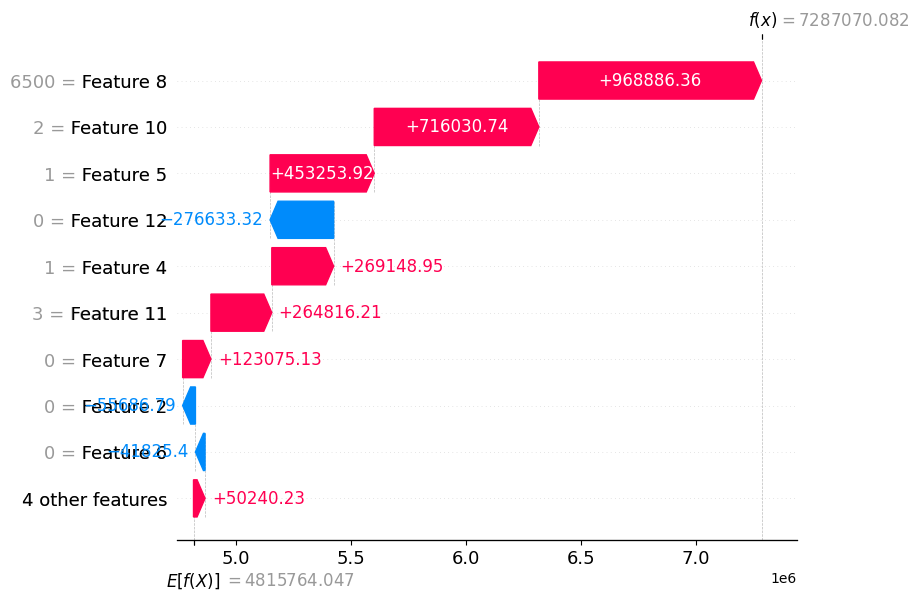


--- SHAP Explanation for Instance 2 ---


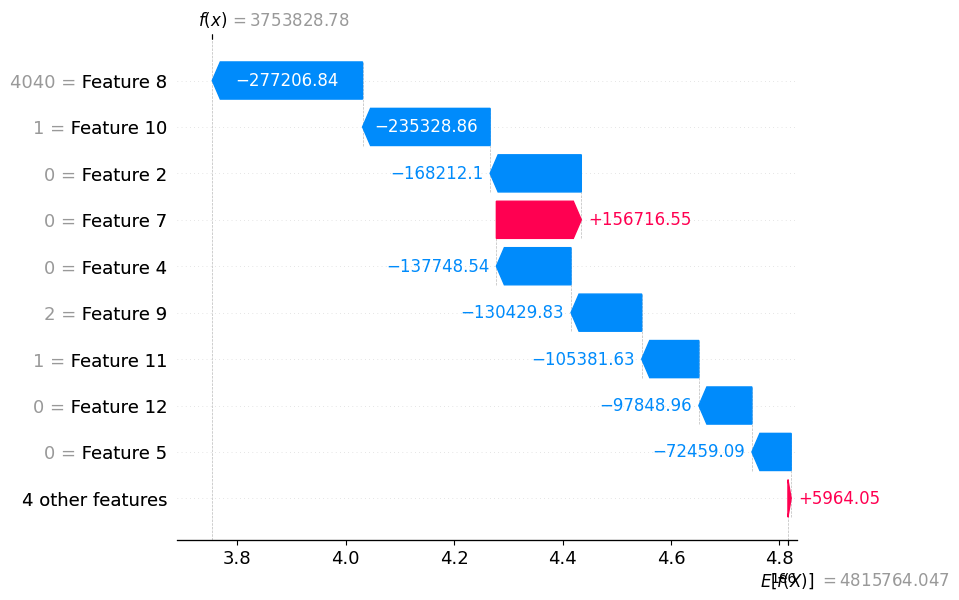

In [ ]:
# Anzahl der Instanzen
n_instances = 3

# SHAP-Werte vorbereiten
X_test_processed = preprocessor.transform(X_test)
explainer = shap.Explainer(model, X_train_processed)
shap_values = explainer(X_test_processed[:n_instances])

# Visualisierung für jede Instanz
for i in range(n_instances):
    print(f"\n--- SHAP Explanation for Instance {i} ---")
    shap.plots.waterfall(shap_values[i])


In [ ]:
# CFs für Instanz 0
cf_0 = exp.generate_counterfactuals(
    test_instance,
    total_CFs=3,
    desired_range=[target_price, target_price + 100000]
)
cf_0.visualize_as_dataframe()

# CFs für Instanz 3–5
cf_additional_results = []
for i in range(3, 6):
    instance = X_test.iloc[[i]].copy()
    pred = pipeline.predict(instance)[0]
    target = pred * 1.2

    cf_i = exp.generate_counterfactuals(
        instance,
        total_CFs=3,
        desired_range=[target, target + 100000]
    )

    cf_df = cf_i.cf_examples_list[0].final_cfs_df
    cf_df.insert(0, "instance_id", i)
    cf_additional_results.append(cf_df)

cf_additional = pd.concat(cf_additional_results, ignore_index=True)


cf_additional




100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Query instance (original outcome : 5377680.0)


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
0,5900,4,2,2,no,no,yes,no,no,1,no,unfurnished,5377680.0



Diverse Counterfactual set (new outcome: [np.float64(6453216.0), np.float64(6553216.0)])


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
0,15140,4,2,2,yes,no,yes,no,no,1,no,unfurnished,6501670.0
1,8087,4,2,2,no,no,yes,no,no,1,no,unfurnished,6516965.0
2,5900,1,2,2,no,no,yes,no,yes,1,no,unfurnished,6472900.0


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


,instance_id,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price
0,3,14131,3,1,2,yes,yes,no,no,yes,0,no,semi-furnished,5456430.0
1,3,15284,3,1,2,yes,no,no,no,yes,0,no,semi-furnished,5459020.0
2,3,5000,3,1,3,yes,no,no,no,yes,0,no,semi-furnished,5459510.0
3,4,3960,3,2,1,yes,no,no,yes,no,0,no,furnished,4516260.0
4,4,3960,3,1,3,yes,no,no,no,yes,0,no,furnished,4557560.0
5,4,3960,3,1,1,yes,yes,no,no,no,2,no,furnished,4526060.0
6,5,6720,3,1,1,yes,no,no,yes,no,0,no,furnished,4213090.0
7,5,11437,3,1,1,yes,no,no,yes,no,0,no,unfurnished,4123140.0
8,5,14589,3,1,1,yes,yes,no,no,no,0,no,unfurnished,4196185.0
